In [1]:
from abc import ABC, abstractmethod

import equinox as eqx
import jax
import jax.numpy as jnp
from jaxtyping import Array, Float
import orc

jax.config.update("jax_enable_x64", True)

class EnsembleEmbedding(orc.embeddings.EmbedBase):
    """Ensemble embedding layer.

    Attributes
    ----------
    in_dim : int
        Reservoir input dimension.
    res_dim : int
        Reservoir dimension.
    scaling : float
        Min/max values of input matrix.
    win : Array
        Input matrix.
    chunks : int
        Number of parallel reservoirs.
    locality : int
        Adjacent reservoir overlap.
    periodic : bool
        Assume periodic BCs.

    Methods
    -------
    __call__(in_state)
        Embed input state to reservoir dimension.
    localize(in_state, periodic=True)
        Decompose input_state to parallel network inputs.
    moving_window(a)
        Helper function for localize.
    embed(in_state)
        Embed single input state to reservoir dimension.
    """

    in_dim: int
    res_dim: int
    scaling: float
    win: Array
    dtype: Float
    chunks: int

    def __init__(
        self,
        in_dim: int,
        res_dim: int,
        scaling: float,
        dtype: Float = jnp.float64,
        chunks: int = 1,
        *,
        seed: int,
    ) -> None:
        """Instantiate linear embedding.

        Parameters
        ----------
        in_dim : int
            Input dimension to reservoir.
        res_dim : int
            Reservoir dimension.
        scaling : float
            Min/max values of input matrix.
        seed : int
            Random seed for generating the PRNG key for the reservoir computer.
        dtype : Float
            Dtype of model, jnp.float64 or jnp.float32.
        periodi : bool
            Assume periodic BCs.
        """
        super().__init__(in_dim=in_dim, res_dim=res_dim, dtype=dtype)
        self.scaling = scaling
        self.dtype = dtype
        key = jax.random.key(seed)


        self.win = jax.random.uniform(
            key,
            (chunks, res_dim, in_dim),
            minval=-scaling,
            maxval=scaling,
            dtype=dtype,
        )
        self.chunks = chunks

    @eqx.filter_jit
    def repeat_states(self, in_state: Array) -> Array:
        """Generate parallel reservoir inputs from input state.

        Parameters
        ----------
        in_state : Array
            Input state, (shape=(in_dim,))

        Returns
        -------
        Array
            Parallel reservoir inputs, (shape=(chunks, group_size + 2*locality))
        """
        if len(in_state.shape) != 1:
            raise ValueError(
                "Only 1-dimensional localization is currently supported, detected a "
                f"{len(in_state.shape)}D field."
            )
        in_state = in_state.reshape(1,-1)
        return jnp.repeat(in_state, self.chunks, axis=0)

    @eqx.filter_jit
    def embed(self, in_state: Array) -> Array:
        """Embed single state to reservoir dimensions.

        Parameters
        ----------
        in_state : Array
            Input state, (shape=(in_dim,)).

        Returns
        -------
        Array
            Embedded input to reservoir, (shape=(chunks, res_dim,)).
        """
        if in_state.shape != (self.in_dim,):
            raise ValueError("Incorrect dimension for input state.")
        repeated_states = self.repeat_states(in_state)

        return eqx.filter_vmap(jnp.matmul)(self.win, repeated_states)
    
    @eqx.filter_jit
    def single_embed(self, in_state):
        return eqx.filter_vmap(jnp.matmul)(self.win, in_state)

    def __call__(self, in_state: Array) -> Array:
        """Embed state to reservoir dimensions.

        Parameters
        ----------
        in_state : Array
            Input state, (shape=(in_dim,) or shape=(seq_len, in_dim)).

        Returns
        -------
        Array
            Embedded input to reservoir, (shape=(chunks, res_dim,) or
            shape=(seq_len, chunks, res_dim)).
        """
        if len(in_state.shape) == 1:
            to_ret = self.embed(in_state)
        elif len(in_state.shape) == 2:
            to_ret = self.batch_embed(in_state)
        else:
            raise ValueError(
                "Only 1-dimensional localization is currently supported, detected a "
                f"{len(in_state.shape) - 1}D field."
            )
        return to_ret


In [2]:
embedding = EnsembleEmbedding(3, 200, chunks=3, scaling = 0.08, seed=0)

In [3]:
class EnsembleReadout(orc.readouts.ReadoutBase):
    """Quadratic readout layer.

    Attributes
    ----------
    out_dim : int
        Dimension of reservoir output.
    res_dim : int
        Reservoir dimension.
    chunks : int
        Number of parallel reservoirs.
    wout : Array
        Output matrix.
    dtype : Float
            Dtype, default jnp.float64.

    Methods
    -------
    readout(res_state)
        Map from reservoir state to output state with quadratic nonlinearity.
    __call__(res_state)
        Map from reservoir state to output state with quadratic nonlinearity,
        handles batch and single outputs.
    """

    out_dim: int
    res_dim: int
    wout: Array
    chunks: int
    dtype: Float

    def __init__(
        self,
        out_dim: int,
        res_dim: int,
        chunks: int = 1,
        dtype: Float = jnp.float64,
        *,
        seed: int = 0,
    ) -> None:
        """Initialize readout layer to zeros.

        Parameters
        ----------
        out_dim : int
            Dimension of reservoir output.
        res_dim : int
            Reservoir dimension.
        chunks : int
            Number of parallel resrevoirs.
        dtype : Float
            Dtype, default jnp.float64.
        seed : int
            Not used for LinearReadout, present to maintain consistent interface.
        """
        super().__init__(out_dim=out_dim, res_dim=res_dim, dtype=dtype)
        self.out_dim = out_dim
        self.res_dim = res_dim
        self.wout = jnp.zeros((chunks, out_dim, res_dim), dtype=dtype)
        self.dtype = dtype
        self.chunks = chunks

    @eqx.filter_jit
    def readout(self, res_state: Array) -> Array:
        """Readout from reservoir state.

        Parameters
        ----------
        res_state : Array
            Reservoir state, (shape=(chunks, res_dim,)).

        Returns
        -------
        Array
            Output from reservoir, (shape=(out_dim,)).
        """
        if res_state.shape[1] != self.res_dim:
            raise ValueError(
                "Incorrect reservoir dimension for instantiated output map."
            )
        
        to_ret = eqx.filter_vmap(jnp.matmul)(self.wout, res_state)
        return jnp.mean(to_ret, axis=0)
    
    @eqx.filter_jit
    def single_readout(self, res_state):
        to_ret = eqx.filter_vmap(jnp.matmul)(self.wout, res_state)
        return to_ret

    def __call__(self, res_state: Array) -> Array:
        """Call either readout or batch_readout depending on dimensions.

        Parameters
        ----------
        res_state : Array
            Reservoir state, (shape=(chunks, res_dim) or
            shape=(seq_len, chunks, res_dim)).

        Returns
        -------
        Array
            Output state, (out_dim,) or shape=(seq_len, out_dim)).
        """
        if len(res_state.shape) == 2:
            to_ret = self.readout(res_state)
        elif len(res_state.shape) == 3:
            to_ret = self.batch_readout(res_state)
        else:
            raise ValueError(
                "Only 1-dimensional localization is currently supported, detected a "
                f"{len(res_state.shape)}D field."
            )
        return to_ret

In [4]:
readout = EnsembleReadout(3, 200, seed=0, chunks=3)

In [5]:
class EnsembleESN(orc.rc.RCForecasterBase):

    """
    Basic implementation of ESN for forecasting.

    Attributes
    ----------
    res_dim : int
        Reservoir dimension.
    data_dim : int
        Input/output dimension.
    driver : ESNDriver
        Driver implmenting the Echo State Network dynamics.
    readout : BaseReadout
        Trainable linear readout layer.
    embedding : LinearEmbedding
        Untrainable linear embedding layer.

    Methods
    -------
    force(in_seq, res_state)
        Teacher forces the reservoir with sequence in_seq and init. cond. res_state.
    forecast(fcast_len, res_state)
        Perform a forecast of fcast_len steps from res_state.
    set_readout(readout)
        Replace readout layer.
    set_embedding(embedding)
        Replace embedding layer.
    """

    res_dim: int
    data_dim: int

    def __init__(
        self,
        data_dim: int,
        res_dim: int,
        leak_rate: float = 0.6,
        bias: float = 1.6,
        embedding_scaling: float = 0.08,
        Wr_density: float = 0.02,
        Wr_spectral_radius: float = 0.8,
        dtype: type = jnp.float64,
        seed: int = 0,
        chunks: int = 1,
        use_sparse_eigs: bool = True
    ) -> None:
        """
        Initialize the ESN model.

        Parameters
        ----------
        data_dim : int
            Dimension of the input data.
        res_dim : int
            Dimension of the reservoir adjacency matrix Wr.
        leak_rate : float
            Integration leak rate of the reservoir dynamics.
        bias : float
            Bias term for the reservoir dynamics.
        embedding_scaling : float
            Scaling factor for the embedding layer.
        Wr_density : float
            Density of the reservoir adjacency matrix Wr.
        Wr_spectral_radius : float
            Largest eigenvalue of the reservoir adjacency matrix Wr.
        dtype : type
            Data type of the model (jnp.float64 is highly recommended).
        seed : int
            Random seed for generating the PRNG key for the reservoir computer.
        chunks : int
            Number of parallel reservoirs, must evenly divide data_dim.
        locality : int
            Overlap in adjacent parallel reservoirs.
        quadratic : bool
            Use quadratic nonlinearity in output, default False.
        periodic : bool
            Periodic BCs for embedding layer.
        use_sparse_eigs : bool
            Whether to use sparse eigensolver for setting the spectral radius of wr.
            Default is True, which is recommended to save memory and compute time. If
            False, will use dense eigensolver which may be more accurate.
        """
        # Initialize the random key and reservoir dimension
        self.res_dim = res_dim
        self.seed = seed
        self.data_dim = data_dim
        key = jax.random.PRNGKey(seed)
        key_driver, key_readout, key_embedding = jax.random.split(key, 3)

        # init in embedding, driver and readout
        embedding = EnsembleEmbedding(
            in_dim=data_dim,
            res_dim=res_dim,
            seed=key_embedding[0],
            scaling=embedding_scaling,
            chunks=chunks,
        )
        driver = orc.drivers.ESNDriver(
            res_dim=res_dim,
            seed=key_driver[0],
            leak=leak_rate,
            bias=bias,
            density=Wr_density,
            spectral_radius=Wr_spectral_radius,
            chunks=chunks,
            dtype=dtype,
            use_sparse_eigs=use_sparse_eigs,
        )
        readout = EnsembleReadout(out_dim=data_dim, res_dim=res_dim,seed=key_readout[0], chunks=chunks)

        super().__init__(
            driver=driver,
            readout=readout,
            embedding=embedding,
            res_dim=res_dim,
            in_dim=data_dim,
            out_dim=data_dim,
            dtype=dtype,
            seed=seed,
        )

    @eqx.filter_jit
    def stat_forecast(self, fcast_len: int, res_state: Array) -> Array:
        """Forecast from an initial reservoir state.

        Parameters
        ----------
        fcast_len : int
            Steps to forecast.
        res_state : Array
            Initial reservoir state, (shape=(res_dim)).

        Returns
        -------
        Array
            Forecasted states, (shape=(fcast_len, data_dim))
        """
        
        def scan_fn(state, _):
            out_state = self.driver(self.embedding.single_embed(self.readout.single_readout(state)), state)
            
            return (out_state, self.readout.single_readout(out_state))

        out_state, out_seq = jax.lax.scan(scan_fn, res_state, None, length=fcast_len)
        return out_state, out_seq

def train_EnsembleForecaster(
    model: EnsembleESN,
    train_seq: Array,
    target_seq: Array = None,
    spinup: int = 0,
    initial_res_state: Array = None,
    beta: float = 8e-8,
) -> tuple[EnsembleESN, Array]:
    """Training function for ESNForecaster.

    Parameters
    ----------
    model : ESNForecaster
        ESNForecaster model to train.
    train_seq : Array
        Training input sequence for reservoir, (shape=(seq_len, data_dim)).
    target_seq : Array
        Target sequence for training reservoir, (shape=(seq_len, data_dim)).
    initial_res_state : Array
        Initial reservoir state, (shape=(chunks, res_dim,)).
    spinup : int
        Initial transient of reservoir states to discard.
    beta : float
        Tikhonov regularization parameter.

    Returns
    -------
    model : ESNForecaster
        Trained ESN model.
    res_seq : Array
        Training sequence of reservoir states.
    """
    if initial_res_state is None:
        initial_res_state = jnp.zeros(
            (
                model.embedding.chunks,
                model.res_dim,
            ),
            dtype=model.dtype,
        )

    if target_seq is None:
        target_seq = train_seq[1:, :]
        train_seq = train_seq[:-1, :]

    res_seq = model.force(train_seq, initial_res_state)
    res_seq_train = res_seq

    print(res_seq.shape)
    print(target_seq.shape)
    target_seq = target_seq.reshape(target_seq.shape[0], 1, target_seq.shape[1])
    target_seq = jnp.repeat(target_seq, model.readout.chunks, axis=1)
    print(target_seq.shape)

    def solve_single_ridge_reg(res_seq, target_seq, beta):
        lhs = res_seq.T @ res_seq + beta * jnp.eye(
            res_seq.shape[1], dtype=res_seq.dtype
        )
        rhs = res_seq.T @ target_seq
        cmat = jax.scipy.linalg.solve(lhs, rhs, assume_a="sym").T
        return cmat
    print(model.readout.wout.shape)
    solve_all_ridge_reg = eqx.filter_vmap(
        solve_single_ridge_reg, in_axes=eqx.if_array(1)
    )
    cmat = solve_all_ridge_reg(
        res_seq_train[spinup:],
        target_seq[spinup:].reshape(res_seq[spinup:].shape[0], res_seq.shape[1], -1),
        beta,
    )
    
    def where(m):
        return m.readout.wout

    model = eqx.tree_at(where, model, cmat)
    print(model.readout.wout.shape)
    return model, res_seq

In [6]:
model = EnsembleESN(3, 1000, seed=0, chunks=32, Wr_spectral_radius=0.4, embedding_scaling=0.1, bias=1.33, leak_rate=0.2)

In [7]:
u,t = orc.data.lorenz63(tN = 120, dt = 0.01)


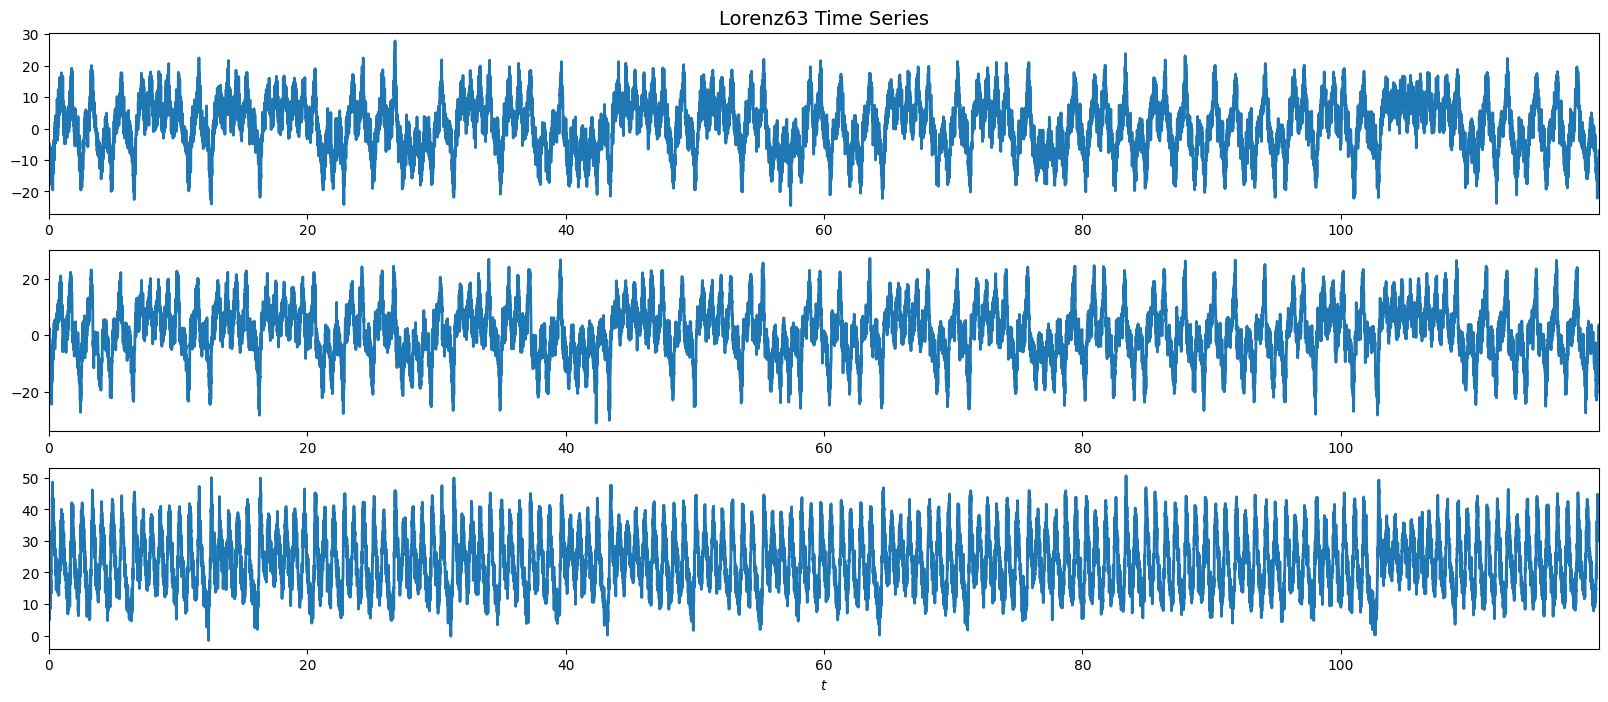

In [8]:
train_seq = u + jax.random.normal(key=jax.random.key(0), shape=u.shape) * 3
orc.utils.visualization.plot_time_series(train_seq, t, title="Lorenz63 Time Series")

In [9]:
train_seq = train_seq[:10000]
model, R = train_EnsembleForecaster(model, train_seq, spinup=200, beta=1e-7)

(9999, 32, 1000)
(9999, 3)
(9999, 32, 3)
(32, 3, 1000)
(32, 3, 1000)


In [10]:
fcast1 = model.forecast(10000, R[-1])

In [11]:
out_state, out_seq = model.stat_forecast(10000, R[-1])

In [12]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

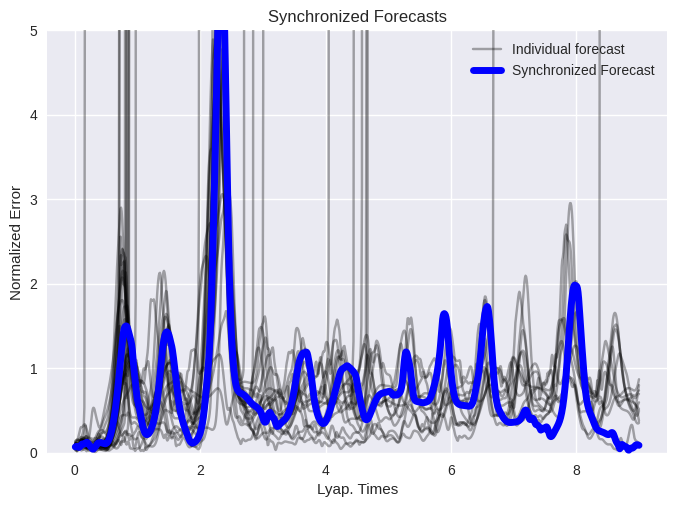

In [13]:

N_range = 1000
t_range = (jnp.arange(1000)* 0.01 + 0.01) * 0.9
for jj in range(32):

    to_plot = jnp.linalg.norm(out_seq[:N_range, jj, :] - u[10000:10000+N_range], axis=1) / jnp.linalg.norm(u[10000:10000+N_range], axis=1)
    if jj == 0:
        plt.plot(t_range, to_plot, 'k', alpha=0.33, label='Individual forecast')
    else:
        plt.plot(t_range, to_plot, 'k', alpha=0.33)
plt.plot(t_range, jnp.linalg.norm(fcast1[:N_range] - u[10000:10000+N_range], axis=1) / jnp.linalg.norm(u[10000:10000+N_range], axis=1),'b', linewidth=5, label='Synchronized Forecast')
plt.ylim([-0.01,5])
plt.ylabel('Normalized Error')
plt.xlabel('Lyap. Times')
plt.title('Synchronized Forecasts')
plt.legend()
plt.show()

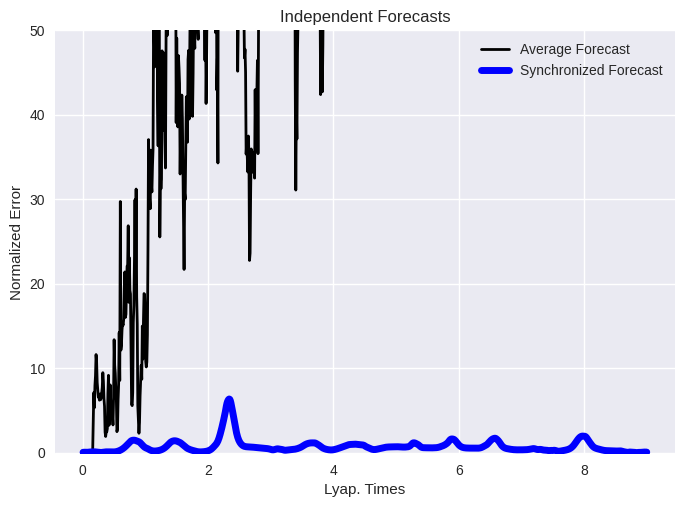

In [14]:
to_plot = jnp.linalg.norm(jnp.mean(out_seq[:N_range],axis=1) -  u[10000:10000+N_range], axis=1) / jnp.linalg.norm(u[10000:10000+N_range], axis=1)

plt.plot(t_range, to_plot, 'k', linewidth=2, label='Average Forecast')
plt.plot(t_range, jnp.linalg.norm(fcast1[:N_range] - u[10000:10000+N_range], axis=1) / jnp.linalg.norm(u[10000:10000+N_range], axis=1), 'b', linewidth=5, label='Synchronized Forecast')

plt.ylim([-0.1,50])
plt.ylabel('Normalized Error')
plt.xlabel('Lyap. Times')
plt.title('Independent Forecasts')
plt.legend()
plt.show()

In [15]:
import numpy as np

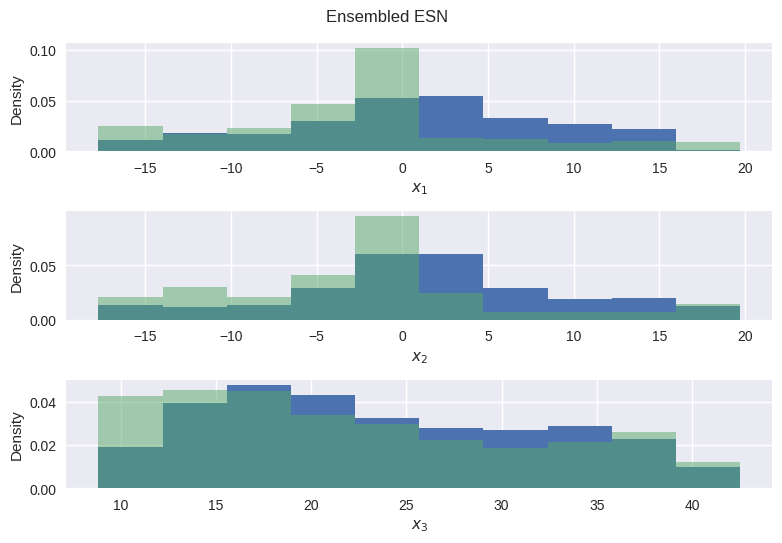

In [16]:
fig, ax = plt.subplots(3)

t1,t2 = np.histogram(fcast1[:,1])
ax[0].set_ylabel('Density')
ax[0].set_xlabel('$x_1$')
ax[0].hist(u[:,0], bins=t2, density=True)
ax[0].hist(fcast1[:,0], bins=t2, density=True, alpha=0.5)


t1,t2 = np.histogram(fcast1[:,1])
ax[1].set_ylabel('Density')
ax[1].set_xlabel('$x_2$')
ax[1].hist(u[:,1], bins=t2, density=True)
ax[1].hist(fcast1[:,1], bins=t2, density=True, alpha=0.5)

t1,t2 = np.histogram(fcast1[:,2])
ax[2].set_ylabel('Density')
ax[2].set_xlabel('$x_3$')
ax[2].hist(u[:,2], bins=t2, density=True)
ax[2].hist(fcast1[:,2], bins=t2, density=True, alpha=0.5)
fig.suptitle('Ensembled ESN')
plt.tight_layout()
plt.show()

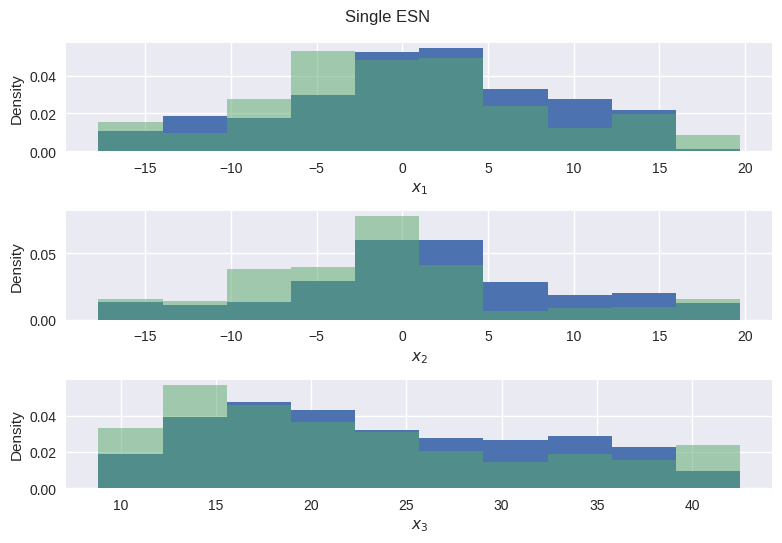

In [17]:

fcast2 = out_seq[:, 15, :]
fig, ax = plt.subplots(3)

t1,t2 = np.histogram(fcast1[:,1])
ax[0].set_ylabel('Density')
ax[0].set_xlabel('$x_1$')
ax[0].hist(u[:,0], bins=t2, density=True)
ax[0].hist(fcast2[:,0], bins=t2, density=True, alpha=0.5)


t1,t2 = np.histogram(fcast1[:,1])
ax[1].set_ylabel('Density')
ax[1].set_xlabel('$x_2$')
ax[1].hist(u[:,1], bins=t2, density=True)
ax[1].hist(fcast2[:,1], bins=t2, density=True, alpha=0.5)

t1,t2 = np.histogram(fcast1[:,2])
ax[2].set_ylabel('Density')
ax[2].set_xlabel('$x_3$')
ax[2].hist(u[:,2], bins=t2, density=True)
ax[2].hist(fcast2[:,2], bins=t2, density=True, alpha=0.5)
fig.suptitle('Single ESN')
plt.tight_layout()
plt.show()

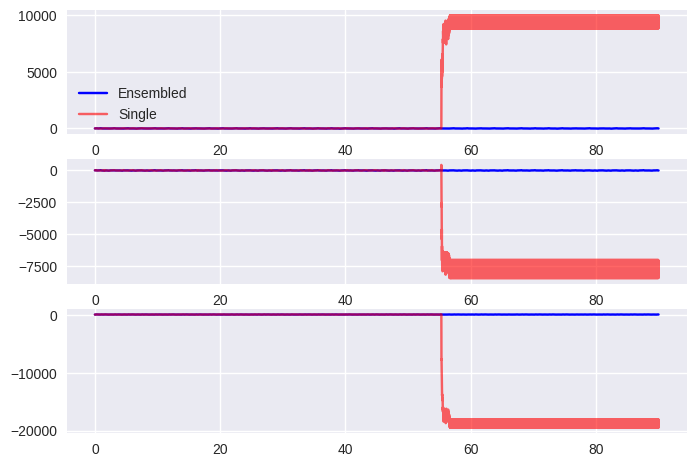

In [18]:
fig, ax = plt.subplots(3)

t_range = 0.01 * 0.9 * np.arange(10000)
ax[0].plot(t_range, fcast1[:,0], 'b', label='Ensembled')
ax[0].plot(t_range, fcast2[:,0], 'r', alpha=0.6, label='Single')

ax[1].plot(t_range, fcast1[:,1], 'b')
ax[1].plot(t_range, fcast2[:,1], 'r', alpha=0.6)

ax[2].plot(t_range, fcast1[:,2], 'b')
ax[2].plot(t_range, fcast2[:,2], 'r', alpha=0.6)
ax[0].legend(loc='lower left')
plt.show()

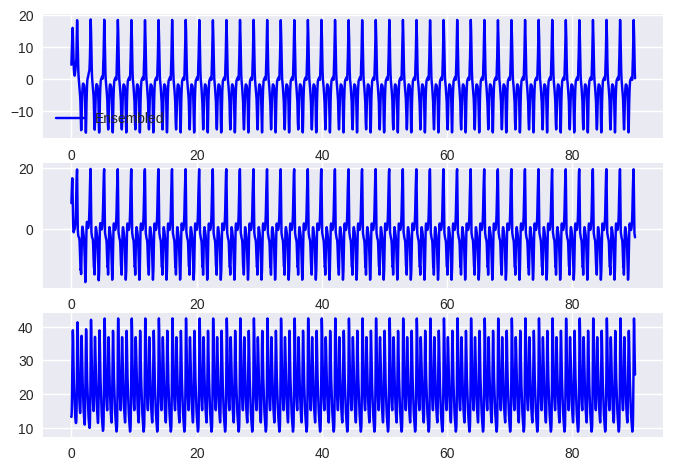

In [19]:
fig, ax = plt.subplots(3)

t_range = 0.01 * 0.9 * np.arange(10000)
ax[0].plot(t_range, fcast1[:,0], 'b', label='Ensembled')


ax[1].plot(t_range, fcast1[:,1], 'b')

ax[2].plot(t_range, fcast1[:,2], 'b')
ax[0].legend(loc='lower left')
plt.show()

In [21]:


model.force(train_seq, jnp.zeros((32, 1000))).shape

(10000, 32, 1000)

In [22]:
to_readout = model.force(train_seq, jnp.zeros((32, 1000)))

In [23]:
readed_out = model.readout(to_readout)

In [24]:
readed_out.shape

(10000, 3)

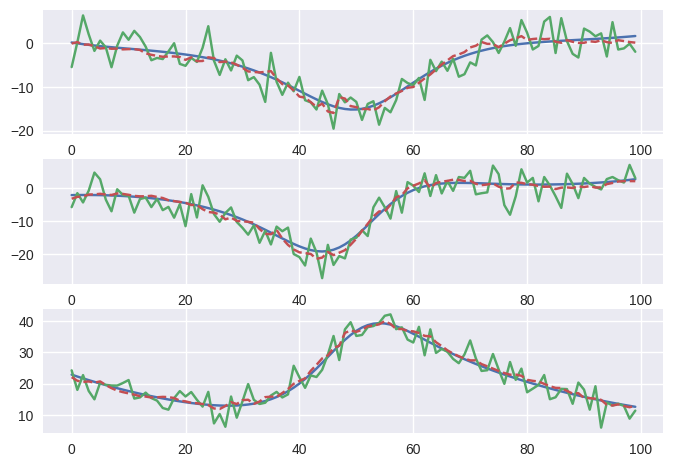

In [38]:
fig, ax = plt.subplots(3)

ax[0].plot(u[201:301, 0 ])
ax[0].plot(train_seq[201:301, 0])
ax[0].plot(readed_out[200:300, 0], '--')


ax[1].plot(u[201:301, 1 ])
ax[1].plot(train_seq[201:301, 1])
ax[1].plot(readed_out[200:300, 1], '--')

ax[2].plot(u[201:301, 2])
ax[2].plot(train_seq[201:301, 2])
ax[2].plot(readed_out[200:300, 2], '--')

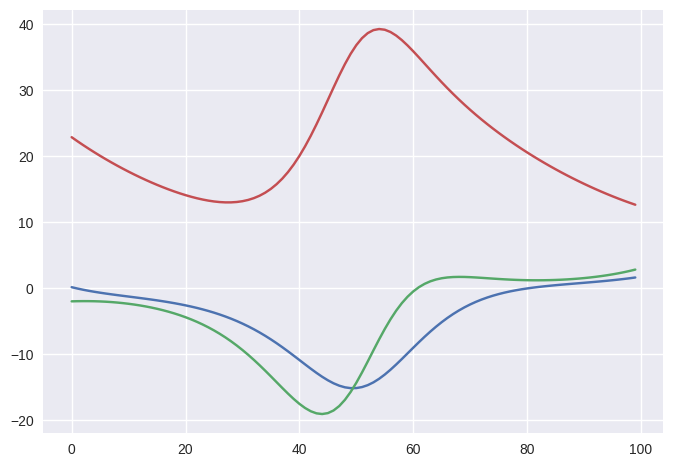

In [32]:
plt.plot(u[201:301])

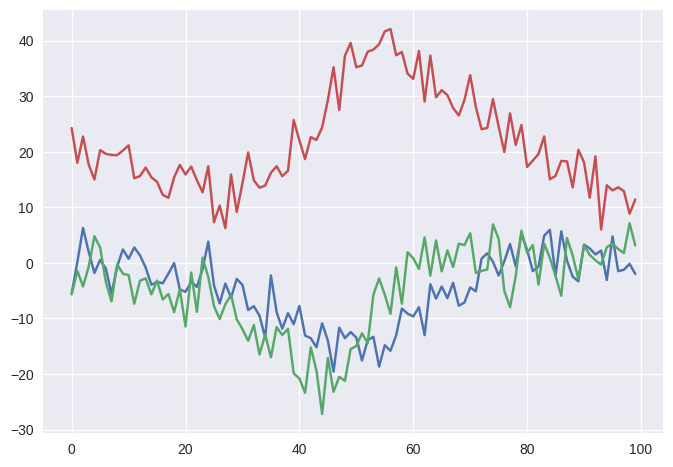

In [34]:
plt.plot(train_seq[201:301])

In [39]:
readed_out.shape

(10000, 3)

In [40]:
model2 = EnsembleESN(3, 1000, seed=0, chunks=32, Wr_spectral_radius=0.4, embedding_scaling=0.1, bias=1.33, leak_rate=0.2)

model2, R = train_EnsembleForecaster(model2, readed_out, spinup=500, beta=1e-7)

(9999, 32, 1000)
(9999, 3)
(9999, 32, 3)
(32, 3, 1000)
(32, 3, 1000)


In [41]:
fcast3 = model2.forecast(10000, R[-1])

In [42]:
out_state, out_seq = model.stat_forecast(10000, R[-1])

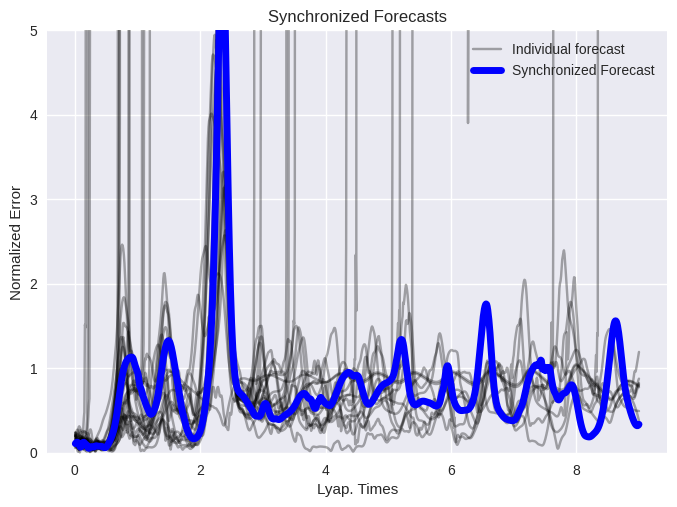

In [43]:

N_range = 1000
t_range = (jnp.arange(1000)* 0.01 + 0.01) * 0.9
for jj in range(32):

    to_plot = jnp.linalg.norm(out_seq[:N_range, jj, :] - u[10000:10000+N_range], axis=1) / jnp.linalg.norm(u[10000:10000+N_range], axis=1)
    if jj == 0:
        plt.plot(t_range, to_plot, 'k', alpha=0.33, label='Individual forecast')
    else:
        plt.plot(t_range, to_plot, 'k', alpha=0.33)
plt.plot(t_range, jnp.linalg.norm(fcast3[:N_range] - u[10000:10000+N_range], axis=1) / jnp.linalg.norm(u[10000:10000+N_range], axis=1),'b', linewidth=5, label='Synchronized Forecast')
plt.ylim([-0.01,5])
plt.ylabel('Normalized Error')
plt.xlabel('Lyap. Times')
plt.title('Synchronized Forecasts')
plt.legend()
plt.show()

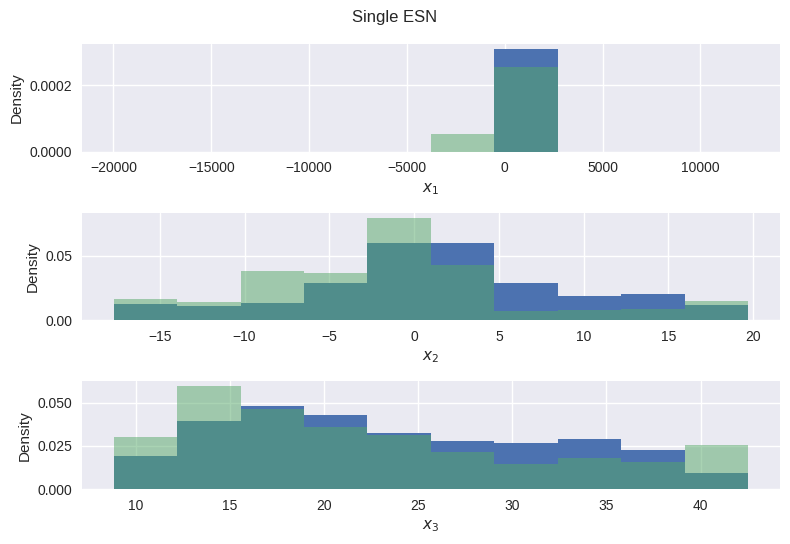

In [44]:

fcast3 = out_seq[:, 15, :]
fig, ax = plt.subplots(3)

t1,t2 = np.histogram(fcast3[:,1])
ax[0].set_ylabel('Density')
ax[0].set_xlabel('$x_1$')
ax[0].hist(u[:,0], bins=t2, density=True)
ax[0].hist(fcast3[:,0], bins=t2, density=True, alpha=0.5)


t1,t2 = np.histogram(fcast1[:,1])
ax[1].set_ylabel('Density')
ax[1].set_xlabel('$x_2$')
ax[1].hist(u[:,1], bins=t2, density=True)
ax[1].hist(fcast3[:,1], bins=t2, density=True, alpha=0.5)

t1,t2 = np.histogram(fcast1[:,2])
ax[2].set_ylabel('Density')
ax[2].set_xlabel('$x_3$')
ax[2].hist(u[:,2], bins=t2, density=True)
ax[2].hist(fcast3[:,2], bins=t2, density=True, alpha=0.5)
fig.suptitle('Single ESN')
plt.tight_layout()
plt.show()

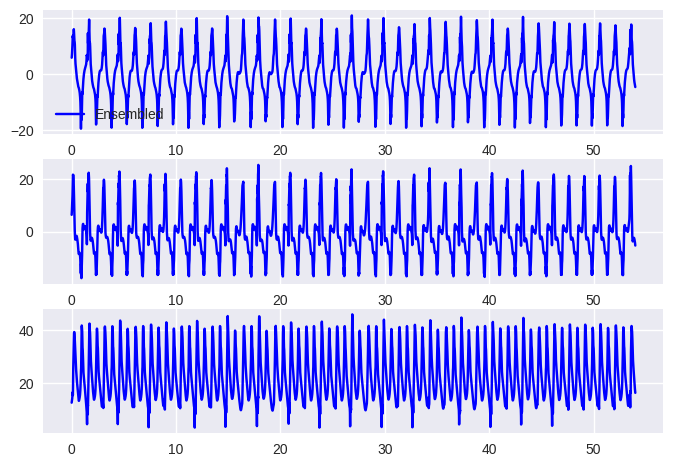

In [47]:
fig, ax = plt.subplots(3)

t_range = 0.01 * 0.9 * np.arange(6000)
ax[0].plot(t_range, fcast3[:6000,0], 'b', label='Ensembled')


ax[1].plot(t_range, fcast3[:6000,1], 'b')

ax[2].plot(t_range, fcast3[:6000,2], 'b')
ax[0].legend(loc='lower left')
plt.show()